In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

# Kunskapskontroll

### Fyll i uppgifterna nedan innan du lämnar in på LearnPoint: 
Namn på samtliga gruppmedlemmar: 

# Project Steps

* Import & Analyze the Data
* Analyze features & measue feature importance
* Clean up data missing values
* Transform Data
* Build pipeline (-> Transform data, Scale Data )
* GridSearch parametergrid for models
* Validate model
* Test model

# Code

#### Loading Data

In [2]:
# Importing Data
data = pd.read_csv(r'.\kunskapskontroll_ai2_del1\housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing = data.drop('median_house_value', axis=1)
housing['target'] = data['median_house_value']

# Transorming 'ocean_proximity' feature using dummy variable encoding
housing = pd.get_dummies(housing, columns=['ocean_proximity'], drop_first=True)

# Defining Median House Value as target variable.
X = housing.drop('target', axis=1)
y = housing['target']

X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,True,False


In [4]:
y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: target, dtype: float64

#### Train Test Split

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

## EDA

#### Checking Missing Values

In [6]:
# Checking for missing Values
housing.isnull().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,target,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False


#### Inspecting Dataset

In [7]:
# Inspecting Dataset
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

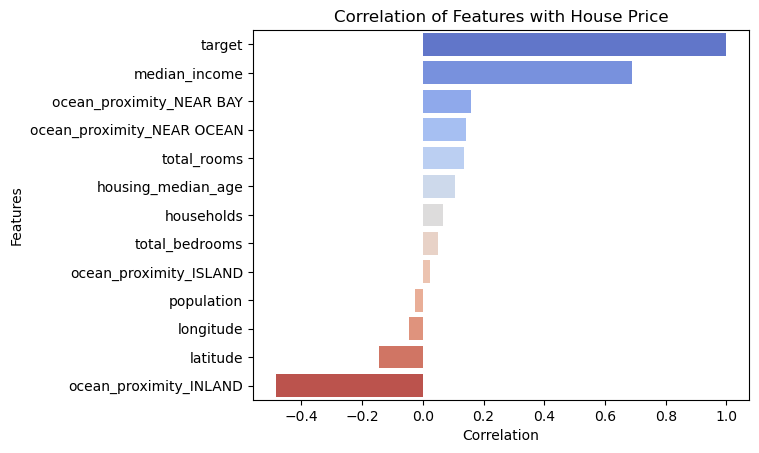

In [19]:
correlation_matrix = housing.corr()
target_correlations = correlation_matrix['target'].sort_values(ascending=False)


# Plot the correlations with the target variable
sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="coolwarm")
plt.title("Correlation of Features with House Price")D
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.show()

In [ ]:
housing

## Data Cleanup

In [ ]:
X.head()

In [ ]:
X.tail()

## Model

In [ ]:


lin_reg = LinearRegression()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg.fit(X_train, y_train)

In [ ]:
lin_reg.score(X_test, y_test)